# SPLEX TME 3
#            Decision Trees and Random Forest

Jérémie Perrin

In [117]:
import pandas as pd
import graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

In [149]:
data_diabetes = pd.read_table('patients_data.txt',sep='\t',header=None)
classes_diabetes = pd.read_table('patients_classes.txt',sep='\t',header=None)

data_train = data_diabetes[:][10:190]
data_test = data_diabetes[:][0:10].append(data_diabetes[:][190:200])

classes_train = classes_diabetes[:][10:190]
classes_test = classes_diabetes[:][0:10].append(classes_diabetes[:][190:200])

## Descision Trees

We first fit the classifier then render as a pdf file the decision diagram.

In [151]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data_train, classes_train)

feature_names = ['age', 'hba1c', 'insuline taken', 'other drugs taken']
classes = ['DR','NDR']
dot_data = tree.export_graphviz(clf, out_file=None,
    feature_names=feature_names,
    class_names=classes,
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
predTree = clf.predict(data_test)
graph.render("diabetes remission")

'diabetes remission.pdf'

Now we draw the decision surfaces for the different pairs of variables.

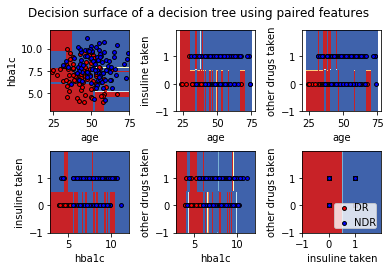

<Figure size 432x288 with 0 Axes>

In [152]:
# Parameters
n_classes = 2
plot_colors = "rb"
plot_step = 0.02

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = data_train[:][pair]
    y = classes_train

    # Train
    clf = tree.DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:][pair[0]].min() - 1, X[:][pair[0]].max() + 1
    y_min, y_max = X[:][pair[1]].min() - 1, X[:][pair[1]].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X.iloc[idx[0]][pair[0]], X.iloc[idx[0]][pair[1]], c=color, label=classes[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
clf = clf.fit(data_train, classes_train)
plt.figure()
plt.show()


## Random Forest

In [153]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = clf.fit(data_train, np.array(classes_train[0]))

/home/gr3w/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [154]:
predForest = clf.predict(data_test)
clf.feature_importances_

array([0.39708883, 0.15159299, 0.31617791, 0.13514027])

## Interpretable Models: comparison with the state-of-the-art clinical score DiaRem

In [156]:

def scoreAge(x):
    if x < 40:
        return 0
    elif x >= 60:
        return 3
    elif x < 50:
        return 1
    else :
        return 2
    
    
def scoreHb(x):
    if x < 6.5:
        return 0
    elif x < 7:
        return 2
    elif x < 9:
        return 4
    else :
        return 6
    
def scoreIns(x):
    if x == 0:
        return 0
    else :
        return 10
    
def scoreDr(x):
    if x == 0:
        return 0
    else :
        return 3
    
def DiaRem(a):
    s = 0
    s += scoreAge(a[0])
    s += scoreHb(a[1])
    s += scoreIns(a[2])
    s += scoreDr(a[3])
    if s > 7:
        return 1
    else :
        return 0
    
y = []
    
for i in range(len(data_test[0])):
    y.append(DiaRem(np.array(data_test.iloc[i])))
        
    

### For Decision trees

Judging function which returns False Positives, True Positives, False Negatives and True Negatives

In [157]:
def res(pred,classes):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(classes)):
        if classes[i] == 1 :
            if pred[i] == 1:
                TP+=1
            else:
                FN+=1
        else:
            if pred[i] == 1:
                FP+=1
            else:
                TN+=1
    return TP,FP,FN,TN


In [158]:

TP,FP,FN,TN = res(predTree,list(classes_test[0]))
print("True Positives  :", TP)
print("False Positives :", FP)
print("False Negatives :", FN)
print("True Negatives  :", TN)

True Positives  : 5
False Positives : 6
False Negatives : 5
True Negatives  : 4


The decision trees clearly overfit as they have a zero error rate on the learning material but behave poorly on the test set.
### For Random Forest


In [159]:
TP,FP,FN,TN = res(predForest,list(classes_test[0]))
print("True Positives  :", TP)
print("False Positives :", FP)
print("False Negatives :", FN)
print("True Negatives  :", TN)


True Positives  : 7
False Positives : 3
False Negatives : 3
True Negatives  : 7


The random forest has a more stable behavior, even though the training error isn't perfect it actually performs similarly on the test set.
### Interpretable model


In [161]:
TP,FP,FN,TN = res(y,list(classes_test[0]))
print("True Positives  :", TP)
print("False Positives :", FP)
print("False Negatives :", FN)
print("True Negatives  :", TN)

True Positives  : 9
False Positives : 5
False Negatives : 1
True Negatives  : 5


The DiaRem seems really good at finding the patients with no diabetes remission. At the cost of diagnocizing non-remission for patients with remission.